# Space Missions EDA

An analysis of the space race based on the Kaggle dataset:
 [All Space Missions from 1957](https://www.kaggle.com/agirlcoding/all-space-missions-from-1957/).

<img src="img/apollo_11_launch.png" alt="First moon landing taking off"/>

## General Information
* Direct link: https://www.kaggle.com/agirlcoding/all-space-missions-from-1957
* Space missions in the time period 1957 - 2020
* Each row represents a rocket launch
* Used fields:
    * Company Name: name of the rocket launching company
    * Location: full address of the launch-site
    * Datum: date of the launch as a string
    * Detail: information on the rockets
    * Status Rocket: retired or active
    *  Rocket: budget for the launch
    * Status Mission: success or degrees of failure

We analyze these aspects:
 * Total launches and success / failure distribution
 * Seasonality
 * Launch positions and frequencies

### Libraries and dataset


In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from timezonefinder import TimezoneFinder
import pytz
import os

df_space = pd.read_csv(os.path.join("data", "Space_Corrected.csv"))

### Data samples


In [311]:
df_space.sample(5)

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
2679,2679,2679,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan","Wed Aug 10, 1977 10:40 UTC",Soyuz U | Zenit-4MKM n†­399,StatusRetired,NaN,Failure
77,77,77,Rocket Lab,"Rocket Lab LC-1A, M?hia Peninsula, New Zealand","Fri Dec 06, 2019 08:18 UTC",Electron/Curie | Running Out Of Fingers,StatusActive,7.5,Success
2128,2128,2128,RVSN USSR,"Site 16/2, Plesetsk Cosmodrome, Russia","Tue Jun 18, 1985 00:40 UTC",Molniya-M /Block 2BL | Cosmos 1661,StatusRetired,NaN,Success
2043,2043,2043,RVSN USSR,"Site 32/1, Plesetsk Cosmodrome, Russia","Tue Sep 30, 1986 18:33 UTC",Tsyklon-3 | Cosmos 1782,StatusRetired,NaN,Success
1284,1284,1284,ESA,"ELA-3, Guiana Space Centre, French Guiana, France","Wed Oct 21, 1998 16:37 UTC",Ariane 5 G | MaqSat 3 & ARD,StatusRetired,NaN,Success


In [312]:
print(f"Number of rows: {df_space.shape[0]}")
print(f"Number of columns: {df_space.shape[1]}")

Number of rows: 4324
Number of columns: 9


## Data Cleaning
Examining the dataframe for missing values and dropping or renaming variables

### Missing values:

In [313]:
df_space.isnull().sum()

Unnamed: 0           0
Unnamed: 0.1         0
Company Name         0
Location             0
Datum                0
Detail               0
Status Rocket        0
 Rocket           3360
Status Mission       0
dtype: int64

We have a problem with the mission cost, which we will address in the data wrangling phase.

#### Fixing names:

In [314]:
df_space = df_space.rename(columns={' Rocket': 'Mission Cost'})


#### Dropping variables:

In [315]:
df_space = df_space.loc[:, ~df_space.columns.str.match('Unnamed')]

## Data Wrangling
Completing the dataframe, solving the missing values issue and merging with geo-locator

#### Joining with data scraped from https://nextspaceflight.com/launches/past/:

In [316]:
df_scraped = pd.read_csv(os.path.join("data", "Scraped.csv"))
df_space.reset_index(drop=True)
df_space_complete = pd.concat([df_scraped, df_space], axis=0)

### Mission cost:
After noticing we had more than 2/3 of the values missing for the mission cost, we checked to
see if a merge with other sources was possible:

In [317]:
df_space_complete['Datum'] = pd.to_datetime(df_space_complete['Datum'], utc=True)
df_budget = df_space_complete[["Datum", "Mission Cost","Detail"]]
df_year = df_budget.resample('Y',on='Datum').agg({"Mission Cost":['count', 'size']})
df_year["Mission Cost","Percentage"] = df_year["Mission Cost","count"]/df_year["Mission Cost","size"]
fig = px.line(x=df_year.index,y=df_year["Mission Cost","Percentage"], height=600)
fig.update_layout(title='Ratio of available v.s. missing data of Mission Cost',
                   xaxis_title='Year',template='plotly_dark',
                   yaxis_title='Frequency of available Mission Cost values')
fig.show()

The missing data is historical in nature and hard to find, rather than
introducing bias in our analysis we decided to drop the variable.

In [318]:
df_space_complete = df_space_complete.drop(["Mission Cost"], axis=1)

#### SpacePort extraction:
we extracted the name of the spaceport from the location string.

In [319]:
df_space_complete["Space Port"] = df_space_complete["Location"].apply(lambda l: ",".join(l.split(",")[1:-1]))
df_space_complete["Space Port"] = df_space_complete["Space Port"].str.strip()
df_space_complete.loc[df_space_complete['Space Port'].str.contains("Māhia Peninsula|M?hia Peninsula", na=False),'Space Port'] \
    = "Rocket Lab"
df_space_complete.loc[df_space_complete['Space Port'].str.contains("West Texas", na=False), 'Space Port'] \
    = "Blue Origin Launch Site"
df_space_complete.loc[df_space_complete['Location'].str.contains("Uchinoura", na=False), 'Space Port'] \
    = "Uchinoura Space Center"
df_space_complete.loc[df_space_complete['Location'].str.contains("Taiyuan", na=False), 'Space Port'] \
    = "Taiyuan Satellite Launch Center"
df_space_complete.loc[df_space_complete['Location'].str.contains("Svobodny", na=False), 'Space Port'] \
    = "Svobodny Cosmodrome"
df_space_complete.loc[df_space_complete['Location'].str.contains("Xichang", na=False), 'Space Port'] \
    = "Xichang Satellite Launch Center"
df_space_complete.loc[df_space_complete['Location'].str.contains("Shahrud", na=False), 'Space Port'] \
    = "Shahrud Missile Test Site"
df_space_complete.loc[df_space_complete['Location'].str.contains("Jiuquan", na=False), 'Space Port'] \
    = "Jiuquan Satellite Launch Center"
df_space_complete.loc[df_space_complete['Location'].str.contains("Pacific Spaceport", na=False), 'Space Port'] \
    = "Pacific Spaceport Complex"
df_space_complete.loc[df_space_complete['Location'].str.contains("Spaceport America", na=False), 'Space Port'] \
    = "Spaceport America"
df_space_complete.loc[df_space_complete['Location'].str.contains("Yellow Sea", na=False), 'Space Port'] \
    = "Yellow Sea"

df_space_complete['Match'] = df_space_complete['Space Port'].astype('category')
df_space_complete['Match'] = df_space_complete[['Match']].apply(lambda x: x.cat.codes)
df_space_complete = df_space_complete.sort_values("Match")
df_space_complete = df_space_complete.sort_values(by=['Space Port'])

### Merging with location dataframe:

You can find both the locations and scraped dataframes on our GitHub:
https://github.com/ChristianPala/SpaceProject

In [320]:
df_location = pd.read_csv(os.path.join("data", "locations_database.csv"))
df_space_complete['Match'] = df_space_complete['Space Port'].astype('category')
df_space_complete['Match'] = df_space_complete[['Match']].apply(lambda x: x.cat.codes)
df_space_complete = df_space_complete.sort_values("Match")
df_combined = pd.merge(df_space_complete, df_location, how="inner", on="Match")

### Companies
We want to give you an overview of the space race, comparing Russia and USA by companies is not very meaningful.

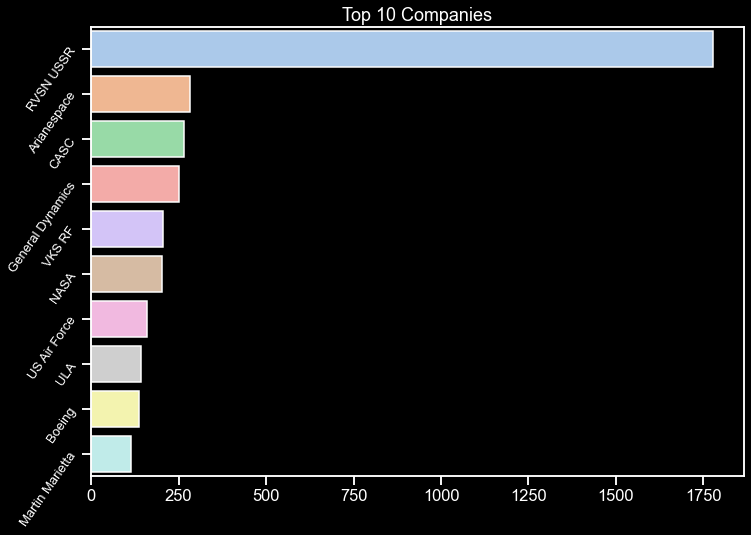

In [321]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

# select the top ten:
df_c = df_combined["Company Name"].value_counts().head(10)
sns.barplot(x=df_c.values, y=df_c.index, palette="pastel")
plt.yticks(size=13, rotation=55)
plt.title("Top 10 Companies", size=18)
plt.show()


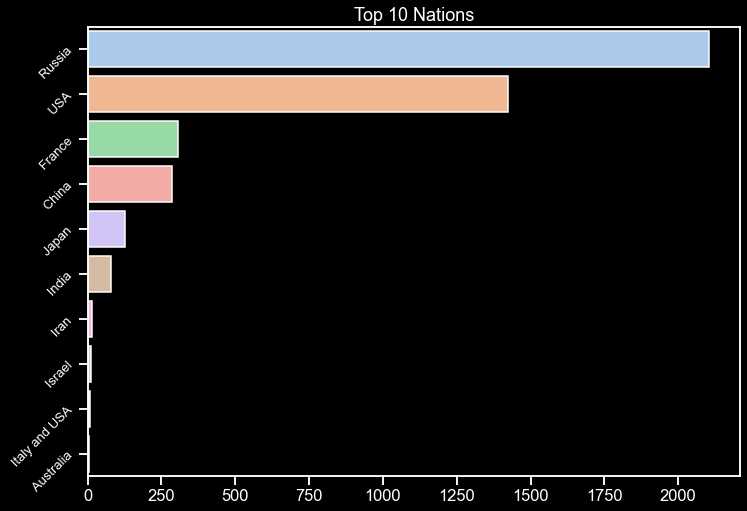

In [322]:
df_o = df_combined["Owner"].value_counts().head(10)
sns.barplot(x=df_o.values, y=df_o.index, palette="pastel")
plt.yticks(size=13, rotation=45)
plt.title("Top 10 Nations", size=18)
plt.show()

Our EDA will focus on nations and not on companies.

### Defining LocalTime:

In [323]:
def define_timezone(latit, long):
    return obj.timezone_at(lat=latit, lng=long)
def define_localtime(date_time, timezone):
    return date_time.tz_convert(timezone).replace(tzinfo=pytz.UTC)
obj = TimezoneFinder()
df_combined['TimeZone'] = df_combined.apply(lambda x: define_timezone(x.Latitude, x.Longitude), axis=1)
df_combined["LocalTime"] = df_combined.apply(lambda x: define_localtime(x.Datum, x.TimeZone), axis=1)

We converted all the times in dataframe to local for a more meaningful analysis.

### Cleaning and presenting:

In [324]:
df_combined = df_combined.loc[:, ~df_combined.columns.str.match('Unnamed')]
df_combined = df_combined.drop(["Location_x", "Space Port_x"], axis=1, errors="ignore")
# Uniform naming convention:
df_combined = df_combined.rename(columns={
    'Company Name': 'CompanyName',
    'Status Rocket': 'RocketStatus',
    'Mission Cost': 'MissionCost',
    'Status Mission': 'MissionStatus',
    'Datum': 'DateTime',
    'Location_y': 'Location',
    'Space Port_y': 'SpacePort'})

df_combined['DateTime'] = pd.to_datetime(df_combined['DateTime'], utc=True)
df_combined['Year'] = df_combined['DateTime'].apply(lambda datetime: datetime.year)
df_combined.info(verbose=True)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4380 entries, 0 to 4379
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   CompanyName    4380 non-null   object             
 1   DateTime       4380 non-null   datetime64[ns, UTC]
 2   Detail         4380 non-null   object             
 3   RocketStatus   4380 non-null   object             
 4   MissionStatus  4380 non-null   object             
 5   Match          4380 non-null   int8               
 6   Location       4380 non-null   object             
 7   Latitude       4380 non-null   float64            
 8   Longitude      4380 non-null   float64            
 9   SpacePort      4380 non-null   object             
 10  Country        4380 non-null   object             
 11  Owner          4380 non-null   object             
 12  TimeZone       4380 non-null   object             
 13  LocalTime      4380 non-null   datetime64[ns, UT

## <h2> EDA <h2>

<h3>1. Total Launches and Failures<h3>
<h3>2. Seasonality<h3>
<h3>3. Positioning<h3>

### Total Launches by year

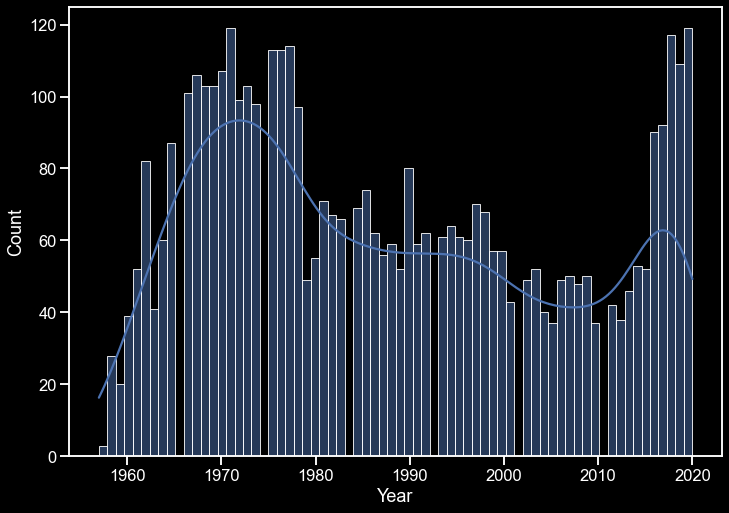

In [325]:
sns.histplot(df_combined, x="Year", kde=True, bins=70)
plt.show()

We had a golden age during the moon race, and it seems to be starting again!

### Rocket and mission status overview

In [326]:
rocket_status = df_combined["RocketStatus"].value_counts()
mission_status = df_combined["MissionStatus"].value_counts()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],subplot_titles=['Status of the Rocket', 'Result of Mission'])
fig.add_trace(go.Pie(labels=rocket_status.index, values=rocket_status.values), 1, 1)
fig.add_trace(go.Pie(labels=mission_status.index, values=mission_status.values), 1, 2)
fig.update_traces(textfont_size=15, textposition="outside")
fig.update_layout(
    title_text="Rocket Analysis",template="plotly_dark",
    annotations=[dict(text='Status of the Rocket', x=0.22, y=-0.2, font_size=20, showarrow=False),
                 dict(text='Result of the Mission', x=0.78, y=-0.2, font_size=20, showarrow=False)])
fig.show()

Most of the rockets are retired, the vast majority of launches was a success.

### Analysis by Nation

In [327]:
df_nation = df_combined[["Owner", "MissionStatus", "RocketStatus"]]
df_success = df_nation.copy()
mask = df_success['MissionStatus'] != "Success"
df_success.loc[mask, 'MissionStatus'] = np.nan
mask = df_success['RocketStatus'] != "StatusActive"
df_success.loc[mask, 'RocketStatus'] = np.nan
df_success = df_success.groupby("Owner").agg({"MissionStatus":['count', 'size'],"RocketStatus":['count', 'size']})
df_success["MissionRatio"] = df_success["MissionStatus", "count"] / df_success["MissionStatus", "size"]
df_success["RocketRatio"] = df_success["RocketStatus", "count"] / df_success["RocketStatus", "size"]
df_success["dim"] = df_success["RocketStatus", "size"]
df_success.sort_values(by="dim",ascending=False, inplace=True)

In [328]:
fig = px.scatter(df_success, x="MissionRatio", y="RocketRatio",
                 size="dim", color=df_success.index, log_x=True, size_max=60, height=700)
fig.update_layout(title='Situation of the World in 2021',
                   xaxis_title='Frequency of successful missions', yaxis_title='Frequency of missions still active', template='plotly_dark')
fig.show()

Russia and the USA have the largest number of missions, but many aren't active anymore.

## Seasonality
In this section we are going to present the trends we identified

### Creating the dataframe for the analysis

In [329]:
df_time = df_combined[["LocalTime", "Owner", "Detail"]].copy()
df_time["LocalTime"] = df_time["LocalTime"].dt.round("H")
df_time.set_index("LocalTime", inplace=True)

data = df_time.groupby(['Owner'])['Detail'].count().sort_values(ascending=False)
top10 = data.iloc[:10]
df_time = df_time[df_time['Owner'].isin(top10.index)]
df_time.head(5)

,Owner,Detail
LocalTime,,
1976-05-05 13:00:00+00:00,Russia,Voskhod | Cosmos 817
1971-08-19 12:00:00+00:00,Russia,Voskhod | Zenit-2M n†­22
1971-09-02 19:00:00+00:00,Russia,Proton K/Block D | Luna-18
2011-11-09 02:00:00+00:00,Russia,Zenit-2 FG | Fobos-Grunt & Yinghuo 1
1971-09-28 13:00:00+00:00,Russia,Voskhod | Cosmos 441


### Launch per Nation per Year

In [330]:
by_year = df_time.groupby([df_time.index.year, "Owner"]).count()
by_year.index.name = "Year"
by_year = by_year.unstack(1)
by_year.replace(float("nan"),0,inplace=True)
by_year = by_year.droplevel(axis=1, level=0)
by_year["Total"] = by_year.sum(axis=1)

In [331]:
fig = px.line(by_year, height=700)
fig.add_annotation(x=1975,y=100,ax=70,text="Space Race End 1975",showarrow=True,
)
fig.update_layout(title_text="Number of Space Mission by top 10 Nations",xaxis_title="Year",
    yaxis_title="Number of Space Mission",legend_title="Nation",title_x=0.5,
    shapes=[dict(type='line',yref='paper', y0=0, y1=1,xref='x', x0=1975, x1=1975,)],
    template='plotly_dark'
)

Russia put a large amount of effort in the 70's to reach the moon, after not reaching their goal
the number of mission dropped drastically.

### Launch per Month

In [332]:
by_months = df_time.groupby(df_time.index.month).count()
by_months.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
by_months.index.name = 'Month'

fig = px.bar(by_months, y="Detail",range_y=[200,500])
fig.update_layout(
    font_size=20, height=600,
    title_text="Mode of Launch per Month",
    xaxis_title="Month",
    yaxis_title="Number of Space Missions",
    title_x=0.5,
    template='plotly_dark',
)
fig.show()

There is no clear pattern, all the values are relatively close to the mean.
We can say the least likely month to start a mission is January and the most likely is December.

### Launch per Day

In [333]:
by_weekday = df_time.groupby(df_time.index.dayofweek).count()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.index.name = 'Day'
fig = px.bar(by_weekday, y="Detail",range_y=[200,900])
fig.update_layout(
    font_size=20, height=700,
    title_text="Mode of Launch per Day",
    xaxis_title="Day",
    yaxis_title="Number of Space Missions",
    title_x=0.5,
    template='plotly_dark'

)
fig.show()

The launches usually take place during workdays, with Thursday being the preferred day.

### Launch per Nation per Hour

In [334]:
df_time = df_combined[["LocalTime", "Owner", "Detail"]].copy()
df_time["LocalTime"] = df_time["LocalTime"].dt.round("H")
df_time.set_index("LocalTime", inplace=True)

by_time_owner = df_time.groupby([df_time.index.time, "Owner"]).count()
by_time_owner.index.name = "Hour"
by_time = by_time_owner.unstack(1)
by_time.replace(float("nan"),0,inplace=True)
by_time = by_time.droplevel(axis=1, level=0)
by_time["Total"] = by_time.sum(axis=1)
fig = px.line(by_time, height=700)
fig.update_layout(
    title_text="Number of Space Mission by top 10 Nations",
    xaxis_title="Hour",
    yaxis_title="Number of Space Mission",
    legend_title="Nation",
    title_x=0.5,
    template='plotly_dark'

)

fig.show()

## Position and frequency of Launches

In [335]:
df_combined['DateTime'] = pd.to_datetime(df_combined['DateTime'], utc=True)
df_combined['Year'] = df_combined['DateTime'].apply(lambda datetime: datetime.year)
df_map = df_combined.sort_values(by=['Year'])

# cumulative sizes:
df_size = df_combined[['Year', 'SpacePort', 'Match']].groupby(['Year', 'SpacePort']).count()
df_size = df_size.groupby('SpacePort').cumsum().reset_index()

# merge the sizes in the original database:
df_map = pd.merge(df_map, df_size, on=['Year', 'SpacePort'])
df_map = df_map.sort_values(by=['Year'])
# token required for the dark-mode in plotly, account needed:
token = "pk.eyJ1IjoiY2hyaXN0aWFuLXBhbGEiLCJhIjoiY2twMDRkbGZ3MGMzbDJubnZreTZjNWJoaSJ9.N4r4lyFLLkgEalTOS4qsuA"

In [336]:
fig = px.scatter_mapbox(
        data_frame=df_map,
        lat=df_map['Latitude'],
        lon=df_map['Longitude'],
        size=df_map['Match_y'],
        size_max=50,# better look.
        color_discrete_sequence=px.colors.qualitative.G10,
        # color=df_combined["Owner"], USA vs Russia.
        hover_name=df_map["Owner"],
        animation_frame=df_map["Year"],
        zoom=0.75
)

fig.update_layout(
        width=1000,
        height=900,
        title_text='Space Race',
        mapbox_style="dark",
        mapbox_accesstoken=token
)
fig.show()

The map shows how many new spaceports are active nowadays compared to the 1960's.

<h1>Thanks for your attention.</h1><br/>
<h1>Questions?</h1>